In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Crank-Nicolson solution zero diffusion across downstream boundary 
#with explicit reaction term that couples concentrations
from scipy.linalg import solve_banded
#define parameters for run
ntimes = 1000
endtime = 2.0
dt = endtime/(ntimes-1)
nx = 1000
Pe = 50.
xmax = 1.
k=0.2 #reaction rate coefficient
dx = xmax/(nx-1.)
#Construct A matrix, which is the same for both equations, and the same as previous C-N solution
A_upper = dt*(1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
A_lower = dt*(-1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
A_mid = (1.+dt/(Pe*dx**2.))*ones(nx-1)
A_upper[0] = 0.
A_lower[-1] = 0.
A_lower[-2] = -dt/(2.*dx)
A_mid[-1] = 1. + dt/(2*dx)
A = vstack((A_upper, A_mid, A_lower))
#Create two concentration arrays for two species
C = zeros([ntimes,nx])
D = zeros([ntimes,nx])
#Set initial conditions for both species
C[0,:]=0.
D[0,:]=0.
#Set upstream boundary concentrations
C_upstream = 1.
D_upstream = 0.
C[:,0] = C_upstream
D[:,0] = D_upstream
#Create b arrays for each concentration variable
bC = zeros(nx-1)
bD = zeros(nx-1)
for n in arange(ntimes-1):
    #Calculate b matrix for C
    bC[0:-1] = C[n,1:-1]*(1.-dt/(Pe*dx**2.)) + C[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe*dx**2.)) \
                        + C[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe*dx**2.))\
                        - dt*k*(C[n,1:-1] - D[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
    bC[0] += dt*(1./(4.*dx) + 1./(2.*Pe*dx**2.))*C_upstream
    bC[-1] = (1.-dt/(2.*dx))*C[n,-1] + (dt/(2*dx))*C[n,-2] - dt*k*(C[n,-1] - D[n,-1])#last term gets added to boundary cond.
    #Calculate b matrix for D
    bD[0:-1] = D[n,1:-1]*(1.-dt/(Pe*dx**2.)) + D[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe*dx**2.))\
                        + D[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe*dx**2.))\
                        + dt*k*(C[n,1:-1] - D[n,1:-1])#Last line here is added to previous C-N solution to include reaction
    bD[0] += dt*(1./(4.*dx) + 1./(2.*Pe*dx**2.))*D_upstream
    bD[-1] = (1.-dt/(2.*dx))*D[n,-1] + (dt/(2*dx))*D[n,-2] + dt*k*(C[n,-1] - D[n,-1])#last term gets added to boundary cond.  
    C[n+1,1:] = solve_banded((1,1), A, bC)
    D[n+1,1:] = solve_banded((1,1), A, bD)
    

Text(0, 0.5, 'Concentration')

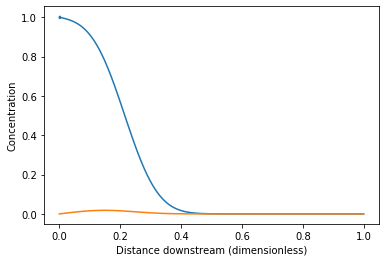

In [3]:
x = linspace(0,1,nx)
plot(x,C[100,:])
plot(x,D[100,:])
xlabel('Distance downstream (dimensionless)')
ylabel('Concentration')

Text(0, 0.5, 'Concentration at Toronto')

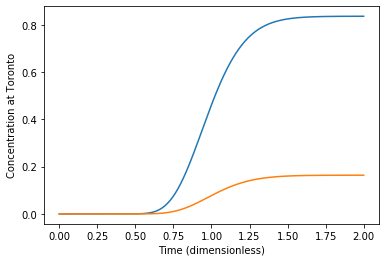

In [4]:
t = linspace(0,endtime,ntimes)
plot(t,C[:,-1])
plot(t,D[:,-1])
xlabel('Time (dimensionless)')
ylabel('Concentration at Toronto')

In [5]:
#Crank-Nicolson solution zero diffusion across downstream boundary 
#with Crank-Nicolson reaction term that couples concentrations.
#Concentrations are solved by creating a single column matrix 
#that contains both C1 and C2.
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import spsolve
#define parameters
ntimes = 1000
endtime = 2.0
dt = endtime/(ntimes-1)
nx = 1000
Pe = 50.
xmax = 1.
k=0.2
dx = xmax/(nx-1.)
#Construct A matrix. Start by creating diagonals of upper left block, which are similar to before 
A_upper = dt*(1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1) 
A_lower = dt*(-1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
A_mid = (1.+dt/(Pe*dx**2.))*ones(nx-1) + dt*k/2.#The middle diagonal gets an added reaction term now
#Knock out elemnts of upper and lower rows for sparse storage
A_upper[0] = 0.
A_lower[-1] = 0.
#Modify lower row for boundary condition
A_lower[-2] = -dt/(2.*dx)
A_mid[-1] = 1. + dt/(2*dx) + dt*k/2.#Again, there is an additional term in the bnd. cond. related to reaction
#Now create full diagonals by appending upper left block diagonals to themselves
A_upper = append(A_upper,A_upper)
A_lower = append(A_lower,A_lower)
A_mid = append(A_mid,A_mid)
#Create upper left and lower right blocks, which only have diagonal non-zero elements
A_up_block_diag = zeros(2*(nx-1))#Diagonal in sparse form is mostly zeros
A_up_block_diag[nx:] = -dt*k/2.#Set non-zero elements in 2nd half of array
A_low_block_diag = zeros(2*(nx-1))
A_low_block_diag[:nx] = -dt*k/2.#Set non-zero elements in 1st half of array
#Create stacked rows version of A
A_tmp = vstack((A_up_block_diag,A_upper, A_mid, A_lower,A_low_block_diag))
#Construct sparse array
offsets = [nx,1,0,-1,-nx]#These indicate the numbers of the non-zero diagonals corresponding to the rows in A_tmp
#Create sparse matrix using dia_matrix:
#  You have to provide the non-zero diagonals and their offsets in a tuple as the first argument.
#  You can also specify the total size of the matrix with the shape keyword
A = dia_matrix((A_tmp,offsets), shape=(2*(nx-1),2*(nx-1)))
#Create concentrations array for both species
C = zeros([ntimes,2*nx])
#Set initial condition
C[0,:]=0.
#set upstream concentrations
C1_upstream = 1.
C2_upstream = 0.
C[:nx,0] = C1_upstream
C[nx:,0] = C2_upstream
#Create both halves of b matrix, they are treated separately below for clarity
bC1 = zeros(nx-1)
bC2 = zeros(nx-1)
for n in arange(ntimes-1):
    #Set C1 and C2 to concentrations of two species at nth timestep
    C1 = C[n,:nx]
    C2 = C[n,nx:]
    #Calculate the components of b for the top half
    bC1[0:-1] = C1[1:-1]*(1.-dt/(Pe*dx**2.)) + C1[0:-2]*(dt/(4.*dx) + dt/(2.*Pe*dx**2.)) \
                        + C1[2:]*(-dt/(4.*dx) + dt/(2.*Pe*dx**2.))\
                        - dt*k*(C1[1:-1] - C2[1:-1])/2. #This row contains reaction term
    bC1[0] += dt*(1./(4.*dx) + 1./(2.*Pe*dx**2.))*C1_upstream
    bC1[-1] = (1.-dt/(2.*dx))*C1[-1] + (dt/(2*dx))*C1[-2] - dt*k*(C1[-1] - C2[-1])/2.#Boundary gets additional reaction term
    bC2[0:-1] = C2[1:-1]*(1.-dt/(Pe*dx**2.)) + C2[0:-2]*(dt/(4.*dx) + dt/(2.*Pe*dx**2.))\
                        + C2[2:]*(-dt/(4.*dx) + dt/(2.*Pe*dx**2.))\
                        + dt*k*(C1[1:-1] - C2[1:-1])/2. #This row contains reaction term
    bC2[0] += dt*(1./(4.*dx) + 1./(2.*Pe*dx**2.))*C2_upstream
    bC2[-1] = (1.-dt/(2.*dx))*C2[-1] + (dt/(2*dx))*C2[-2] + dt*k*(C1[-1] - C2[-1]) /2.#Boundary gets additional reaction term
    #Put together upper and lower halves of b
    b = append(bC1,bC2)
    #Use sparse linear solver
    Ctmp = spsolve(A, b)
    #Assign values from solver into C array avoiding upstream boundary locations (first row of each half of C)
    C[n+1,1:nx] = Ctmp[:nx-1]
    C[n+1,nx+1:] = Ctmp[nx-1:]
    

/home/mcoving/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Text(0, 0.5, 'Concentration')

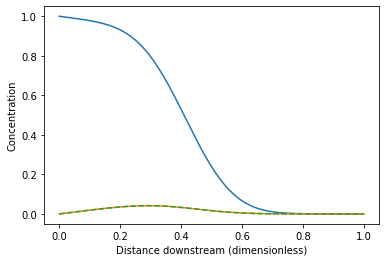

In [6]:
x = linspace(0,1,nx)
plot(x,C[200,:nx])
plot(x,C[200,nx:])
#Can compare against previous solution for D
plot(x,D[200,:],'--')

xlabel('Distance downstream (dimensionless)')
ylabel('Concentration')